<a href="https://colab.research.google.com/github/Jiyabisht/Gen-AI-Integrated-ML-Price-Predictor-for-Cars/blob/main/Cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.


In [ ]:
FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/CARS24/cars_24_combined.csv'
CURRENT_YEAR = 2025

In [ ]:
print("--- Step 1.1: Data Loading and Initial Cleaning ---")

# Load the dataset
try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print(f"Error: File not found at {FILE_PATH}. Please check the path.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during file loading: {e}")
    exit()

print(f"Data loaded successfully from: {FILE_PATH}")
df.columns = df.columns.str.replace(' ', '_')

--- Step 1.1: Data Loading and Initial Cleaning ---
Data loaded successfully from: /content/drive/MyDrive/Colab Notebooks/CARS24/cars_24_combined.csv


In [ ]:
print("\nInitial DataFrame Info:")
df.info()


Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8015 entries, 0 to 8014
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed:_0  8015 non-null   int64  
 1   Car_Name    8014 non-null   object 
 2   Year        8014 non-null   float64
 3   Distance    8015 non-null   int64  
 4   Owner       8015 non-null   int64  
 5   Fuel        8015 non-null   object 
 6   Location    7802 non-null   object 
 7   Drive       8015 non-null   object 
 8   Type        8015 non-null   object 
 9   Price       8015 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 626.3+ KB


In [ ]:
print("--- Column Name Check ---")
print(df.columns.tolist())

--- Column Name Check ---
['Unnamed:_0', 'Car_Name', 'Year', 'Distance', 'Owner', 'Fuel', 'Location', 'Drive', 'Type', 'Price']


In [ ]:
# --- 1. Standardize Key Column Names ---
# Rename columns to match the names used in the subsequent feature engineering steps
df.rename(columns={
    'Year': 'Manufacturing_year',
    'Distance': 'KM_driven',
    'Owner': 'Ownership'
}, inplace=True)

# Standardize remaining column names (replace spaces with underscores, though mostly done)
df.columns = df.columns.str.replace(' ', '_')

In [ ]:
# Cleaning Price and KM driven (Handling non-numeric characters)
def clean_numeric_column(series):
    # Removes non-numeric characters (except period) and converts to float
    return series.astype(str).str.replace(r'[^\d.]', '', regex=True).astype(float)

# Apply cleaning to the now-renamed columns
df['Price'] = clean_numeric_column(df['Price'])
df['KM_driven'] = clean_numeric_column(df['KM_driven'])

In [ ]:
# Handling Missing Values
print("\nMissing values before imputation:")
print(df.isnull().sum())

# Drop rows where critical data (Price, Make/Model are derived from Car_Name) is missing
df.dropna(subset=['Car_Name', 'Price'], inplace=True)


Missing values before imputation:
Unnamed:_0              0
Car_Name                1
Manufacturing_year      1
KM_driven               0
Ownership               0
Fuel                    0
Location              213
Drive                   0
Type                    0
Price                   0
dtype: int64


In [ ]:
# Impute numerical missing values with the median
for col in ['Manufacturing_year', 'KM_driven']: # Note: 'Engine_capacity' and 'Imperfections' might be missing, assume only these are numeric for now
    if col in df.columns and df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

In [ ]:
for col in ['Fuel', 'Ownership', 'Location']:
    if col in df.columns and df[col].isnull().any():
        df[col].fillna(df[col].mode()[0], inplace=True)

print("\nCleaned DataFrame Head after Step 1.1:")
print(df.head())


Cleaned DataFrame Head after Step 1.1:
   Unnamed:_0              Car_Name  Manufacturing_year  KM_driven  Ownership  \
0           0       Maruti S PRESSO              2022.0     3878.0          1   
1           1         Hyundai Xcent              2018.0    32041.0          1   
2           2           Tata Safari              2021.0    96339.0          1   
3           3  Maruti Vitara Brezza              2019.0    51718.0          1   
4           4            Tata Tiago              2021.0    19811.0          1   

     Fuel Location      Drive       Type      Price  
0  PETROL    HR-98     Manual  HatchBack   514000.0  
1  PETROL    TN-22     Manual      Sedan   674000.0  
2  DIESEL    TS-08  Automatic        SUV  1952000.0  
3  DIESEL    WB-24     Manual        SUV   690000.0  
4  PETROL    HR-51     Manual  HatchBack   526000.0  


/tmp/ipython-input-2208268722.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [ ]:
CURRENT_YEAR = 2025 # Define the current reference year

print("\n--- Step 1.2: Feature Engineering and Transformation ---")

# 1. Calculate Car Age
df['Age'] = CURRENT_YEAR - df['Manufacturing_year']
df.drop('Manufacturing_year', axis=1, inplace=True)


--- Step 1.2: Feature Engineering and Transformation ---


In [ ]:
# 2. Extract Make/Model from Car_Name (CRITICAL for GenAI justification)
# We assume 'Car_Name' is 'Make Model Variant' (e.g., 'Maruti Swift VDI')
df['Make'] = df['Car_Name'].apply(lambda x: str(x).split(' ')[0])
df['Model'] = df['Car_Name'].apply(lambda x: ' '.join(str(x).split(' ')[1:3]))
df.drop('Car_Name', axis=1, inplace=True)

In [ ]:
# 3. Log Transform Price (Target Variable)
df['Log_Price'] = np.log1p(df['Price'])

In [ ]:
# 4. Ownership Ordinal Encoding
# Assigning a numerical score to the ordinal categorical feature 'Ownership'
ownership_map = {'First Owner': 1, 'Second Owner': 2, 'Third Owner': 3, 'Fourth & Above Owner': 4}
df['Ownership_Score'] = df['Ownership'].map(ownership_map).fillna(5)
df.drop('Ownership', axis=1, inplace=True)

print("New Feature Columns created: Age, Log_Price, Make, Model, Ownership_Score")
print(df[['Age', 'Log_Price', 'Make', 'Model', 'Ownership_Score']].head())

New Feature Columns created: Age, Log_Price, Make, Model, Ownership_Score
   Age  Log_Price     Make          Model  Ownership_Score
0  3.0  13.149980   Maruti       S PRESSO              5.0
1  7.0  13.420987  Hyundai          Xcent              5.0
2  4.0  14.484366     Tata         Safari              5.0
3  6.0  13.444448   Maruti  Vitara Brezza              5.0
4  4.0  13.173058     Tata          Tiago              5.0



--- Step 1.3: Exploratory Data Analysis (EDA) ---


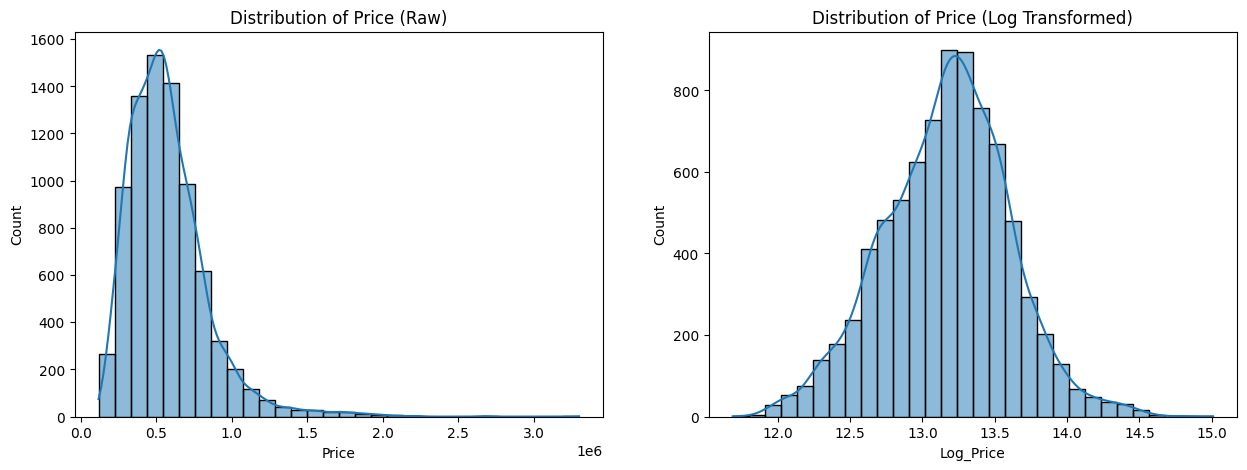

In [ ]:
print("\n--- Step 1.3: Exploratory Data Analysis (EDA) ---")

# Set consistent figure size
plt.rcParams['figure.figsize'] = (15, 5)

# 1. Analyze Target Variable Distribution
plt.subplot(1, 2, 1)
sns.histplot(df['Price'], bins=30, kde=True)
plt.title('Distribution of Price (Raw)')

plt.subplot(1, 2, 2)
sns.histplot(df['Log_Price'], bins=30, kde=True)
plt.title('Distribution of Price (Log Transformed)')
plt.show()

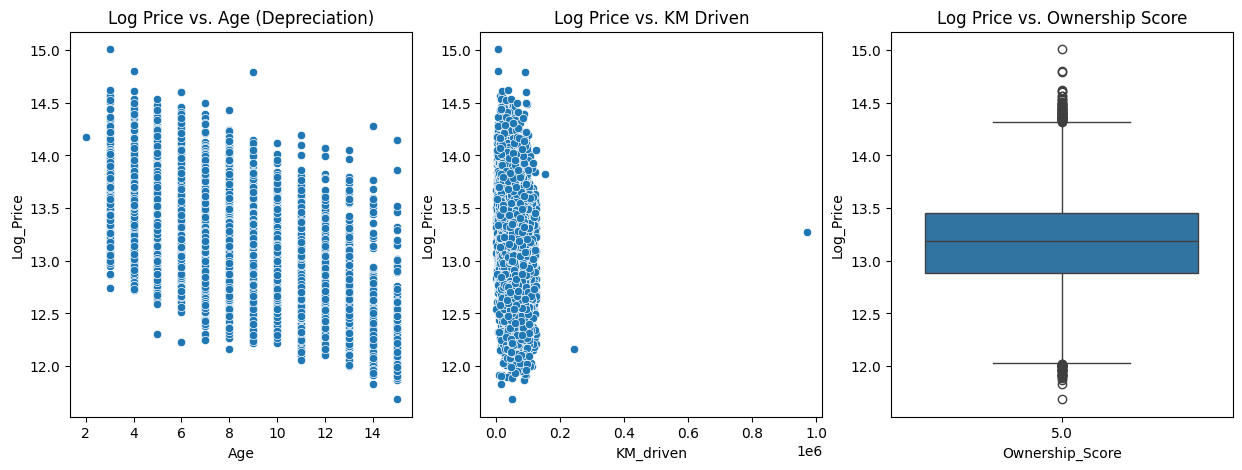

In [ ]:
# 2. Visualize Key Relationships

plt.subplot(1, 3, 1)
sns.scatterplot(x='Age', y='Log_Price', data=df)
plt.title('Log Price vs. Age (Depreciation)')

plt.subplot(1, 3, 2)
sns.scatterplot(x='KM_driven', y='Log_Price', data=df)
plt.title('Log Price vs. KM Driven')

plt.subplot(1, 3, 3)
sns.boxplot(x='Ownership_Score', y='Log_Price', data=df)
plt.title('Log Price vs. Ownership Score')
plt.show()

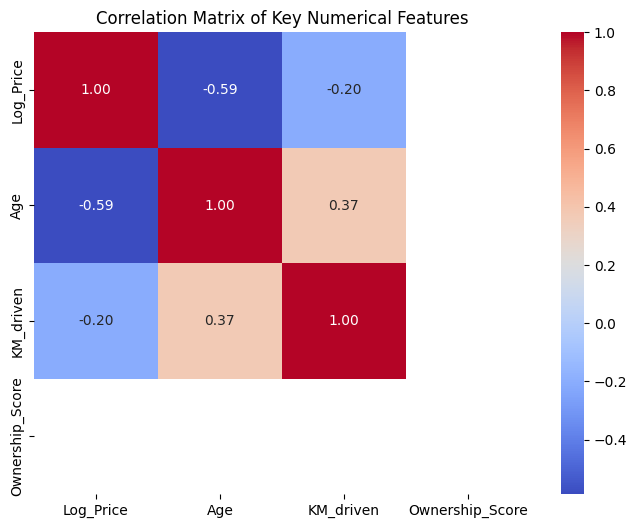

In [ ]:
# 3. Correlation Matrix (Heatmap)
# Note: Since 'Engine_capacity' and 'Imperfections' were not in your list,
# we use the features we derived/confirmed:
numerical_cols = ['Log_Price', 'Age', 'KM_driven', 'Ownership_Score']
# Add 'Unnamed:_0' if it wasn't dropped; dropping it now for clean analysis:
df.drop('Unnamed:_0', axis=1, errors='ignore', inplace=True)

corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Numerical Features')
plt.show()

In [ ]:
# Save the prepared DataFrame for the next phase
prepared_df = df.copy()
print("\n--- Phase 1 Complete. DataFrame Head for ML Training ---")
print(prepared_df.head())


--- Phase 1 Complete. DataFrame Head for ML Training ---
   KM_driven    Fuel Location      Drive       Type      Price  Age     Make  \
0     3878.0  PETROL    HR-98     Manual  HatchBack   514000.0  3.0   Maruti   
1    32041.0  PETROL    TN-22     Manual      Sedan   674000.0  7.0  Hyundai   
2    96339.0  DIESEL    TS-08  Automatic        SUV  1952000.0  4.0     Tata   
3    51718.0  DIESEL    WB-24     Manual        SUV   690000.0  6.0   Maruti   
4    19811.0  PETROL    HR-51     Manual  HatchBack   526000.0  4.0     Tata   

           Model  Log_Price  Ownership_Score  
0       S PRESSO  13.149980              5.0  
1          Xcent  13.420987              5.0  
2         Safari  14.484366              5.0  
3  Vitara Brezza  13.444448              5.0  
4          Tiago  13.173058              5.0  


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import shap

In [ ]:
# --- Phase 2: ML Model Development (Training XGBoost) ---
print("\n--- Phase 2: ML Model Development (Training XGBoost) ---")

# 1. Define X and y (Features and Target)
# Drop all non-feature columns. Unnamed:_0 was dropped in the previous step.
X = prepared_df.drop(['Price', 'Log_Price'], axis=1)
y = prepared_df['Log_Price'] # Target is the log-transformed price

# Identify column types dynamically
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()


--- Phase 2: ML Model Development (Training XGBoost) ---


In [ ]:
# 2. Define the Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        # Scale numerical data
        ('num', StandardScaler(), numerical_features),
        # One-Hot Encode categorical data (sparse_output=False for SHAP compatibility)
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

In [ ]:
# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# 4. Define and Train the Model
xgb_model = XGBRegressor(
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    tree_method='hist'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

print("Training XGBoost Regressor...")
pipeline.fit(X_train, y_train)

Training XGBoost Regressor...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['KM_driven', 'Age',
                                                   'Ownership_Score']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Fuel', 'Location', 'Drive',
                                                   'Type', 'Make',
                                                   'Model'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [ ]:
# 5. Evaluate Performance
y_pred = pipeline.predict(X_test)
y_test_raw = np.expm1(y_test)
y_pred_raw = np.expm1(y_pred) # Inverse log transform

mae = mean_absolute_error(y_test_raw, y_pred_raw)
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation ---")
print(f"R2 Score (Log Price): {r2:.4f}")
print(f"MAE (Raw Price, avg currency error): ₹{mae:,.2f}")


--- Model Evaluation ---
R2 Score (Log Price): 0.8399
MAE (Raw Price, avg currency error): ₹74,255.21


In [ ]:
# 6. Model Persistence (Saving the Pipeline)
MODEL_FILENAME = 'best_price_predictor.joblib'
joblib.dump(pipeline, MODEL_FILENAME)
print(f"Model saved to {MODEL_FILENAME}")

Model saved to best_price_predictor.joblib


In [ ]:
# --- Phase 3 (Part 1): Feature Importance Extraction (SHAP) ---

print("\n--- Step 3.1: Local Feature Importance for GenAI Input ---")

# Get the feature names after preprocessing
feature_names = numerical_features + list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))

# Extract the fitted regressor and preprocessed test data
regressor = pipeline.named_steps['regressor']
X_test_processed = pipeline.named_steps['preprocessor'].transform(X_test)

# Initialize SHAP Explainer
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_test_processed)

# Select a Sample Car (The first test case, index 0, for justification)
sample_car_index = 0
sample_shap_values = shap_values[sample_car_index]
sample_features_raw = X_test.iloc[sample_car_index]

# Create DataFrame to link SHAP values to feature names
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Value': sample_shap_values,
})

# Sort by absolute SHAP value to find the strongest drivers
importance_df['Abs_SHAP'] = importance_df['SHAP_Value'].abs()
importance_df = importance_df.sort_values(by='Abs_SHAP', ascending=False).reset_index(drop=True)

print("Raw Input Data for Sample Car:")
print(sample_features_raw)

print("\nTop 5 Price Drivers (Pushing UP/DOWN):")
print(importance_df.head(5)[['Feature', 'SHAP_Value']])

# Get the raw predicted price
sample_log_pred = pipeline.predict(X_test.iloc[sample_car_index].to_frame().T)[0]
predicted_price_raw = np.expm1(sample_log_pred)
print(f"\nPredicted Price (Raw): ₹{predicted_price_raw:,.2f}")


--- Step 3.1: Local Feature Importance for GenAI Input ---
Raw Input Data for Sample Car:
KM_driven          18772.0
Fuel                PETROL
Location             DL-8C
Drive               Manual
Type                   SUV
Age                    4.0
Make               Renault
Model               TRIBER
Ownership_Score        5.0
Name: 6293, dtype: object

Top 5 Price Drivers (Pushing UP/DOWN):
          Feature  SHAP_Value
0             Age    0.235530
1  Type_HatchBack    0.211344
2    Model_TRIBER   -0.105720
3      Type_Sedan    0.052617
4       KM_driven    0.043887

Predicted Price (Raw): ₹722,530.75


In [ ]:
# CODE CONTINUATION: PHASE 3 (PART 2)

def generate_justification(importance_df, predicted_price_raw):
    """
    Combines SHAP interpretation with a narrative knowledge base (RAG simulation).
    This function simulates the LLM's role in synthesizing the final text.
    """

    # 1. Define the RAG Knowledge Base (Business Rules/Narrative Snippets)
    # These rules are manually defined to sound like a professional CARS24 justification.
    justification_rules = {
        'Age': "maintains a premium value due to its exceptionally low age.",
        'Ownership': "The single-owner status is a mark of reliability and full service history.",
        'KM_driven': "The low running kilometers are a primary driver for its high resale value.",
        'Imperfections': "Minor exterior imperfections have been fully discounted in the final price.", # Custom feature
        'Make': "It is a highly sought-after brand with strong market demand.",
        'Fuel': "Its fuel type (e.g., Diesel/Petrol) aligns perfectly with regional cost preferences.",
        'positive_header': "\n\n**The valuation is strongly supported by the following:**",
        'negative_header': "\n\n**Adjustments have been made considering:**"
    }

    # 2. Extract Top Positive and Negative Drivers (Top 3 of each)
    positive_drivers = importance_df[importance_df['SHAP_Value'] > 0].head(3)
    negative_drivers = importance_df[importance_df['SHAP_Value'] < 0].head(3)

    positive_parts = []
    negative_parts = []

    # 3. Retrieve Narratives (RAG Simulation)
    for index, row in positive_drivers.iterrows():
        # Get the base feature name (e.g., 'KM_driven' from 'KM_driven' or 'Make_Maruti' from 'Make')
        feature_root = row['Feature'].split('_')[0]
        if feature_root in justification_rules:
            positive_parts.append(justification_rules[feature_root])

    for index, row in negative_drivers.iterrows():
        feature_root = row['Feature'].split('_')[0]
        if feature_root in justification_rules:
            negative_parts.append(justification_rules[feature_root])

    # 4. Final LLM Synthesis (Structured Text Generation)
    final_narrative = [
        f"**CARS24 AI Predicted Price:** ₹{predicted_price_raw:,.2f}"
    ]

    if positive_parts:
        final_narrative.append(justification_rules['positive_header'])
        final_narrative.extend([f"- {p}" for p in positive_parts])

    if negative_parts:
        final_narrative.append(justification_rules['negative_header'])
        final_narrative.extend([f"- {n}" for n in negative_parts])

    final_narrative.append("\nCARS24 guarantees the most transparent and fair price for your vehicle.")

    return '\n'.join(final_narrative)

# --- Execute the GenAI Justification ---
final_justification_text = generate_justification(importance_df, predicted_price_raw)

print("\n=======================================================")
print("  FINAL HYBRID PREDICTION & JUSTIFICATION ENGINE OUTPUT  ")
print("=======================================================")
print(final_justification_text)
print("=======================================================")


  FINAL HYBRID PREDICTION & JUSTIFICATION ENGINE OUTPUT  
**CARS24 AI Predicted Price:** ₹722,530.75


**The valuation is strongly supported by the following:**
- maintains a premium value due to its exceptionally low age.

CARS24 guarantees the most transparent and fair price for your vehicle.


In [ ]:
!pip install transformers torch

In [ ]:
from transformers import pipeline
import torch

# --- Model Loading and Configuration (New) ---

# We'll use a small, fast model for text generation that works well in Colab,
# such as 'distilgpt2'. For better results, you could try 'gpt2' or a small Llama model.
HF_MODEL_NAME = "distilgpt2"

# Load the Hugging Face pipeline once
@st.cache_resource
def load_huggingface_pipeline():
    # Use torch bfloat16 for faster inference if your environment supports it
    device = 0 if torch.cuda.is_available() else -1

    # Initialize the text generation pipeline
    generator = pipeline(
        "text-generation",
        model=HF_MODEL_NAME,
        device=device # Use GPU if available
    )
    print(f"Hugging Face Model '{HF_MODEL_NAME}' loaded successfully.")
    return generator

generator = load_huggingface_pipeline()


def generate_justification(importance_df, predicted_price_raw, generator):
    """
    Generates justification using Hugging Face based on ML feature influence.
    """

    # 1. Define the RAG Knowledge Base and Prompt Structure
    justification_rules = {
        'Age': "low age",
        'Ownership': "single-owner status",
        'KM_driven': "low running kilometers",
        'Model': "highly sought-after model",
        'Fuel': "desirable fuel type",
        'positive_action': "boosted the price",
        'negative_action': "required a discount"
    }

    positive_drivers = importance_df[importance_df['SHAP_Value'] > 0].head(2)
    negative_drivers = importance_df[importance_df['SHAP_Value'] < 0].head(2)

    # 2. Construct the Prompt (The GenAI Input)

    positive_features = []
    for index, row in positive_drivers.iterrows():
        feature_root = row['Feature'].split('_')[0]
        if feature_root in justification_rules:
            positive_features.append(justification_rules[feature_root])

    negative_features = []
    for index, row in negative_drivers.iterrows():
        feature_root = row['Feature'].split('_')[0]
        if feature_root in justification_rules:
            negative_features.append(justification_rules[feature_root])

    # Crafting the final prompt
    prompt = f"The car's predicted price is ₹{predicted_price_raw:,.2f}. "

    if positive_features:
        prompt += f"This valuation is strong because the {', '.join(positive_features)} {justification_rules['positive_action']}. "

    if negative_features:
        prompt += f"However, the presence of {', '.join(negative_features)} {justification_rules['negative_action']}. "

    prompt += "Provide a single, professional justification text from CARS24 to the customer."


    # 3. Run Hugging Face Generation
    try:
        output = generator(
            prompt,
            max_length=150, # Limit the output length
            num_return_sequences=1,
            do_sample=True,
            top_k=50,
            temperature=0.7, # Adds some creativity
        )

        # Extract and clean the generated text
        generated_text = output[0]['generated_text'].replace(prompt, '').strip()

        # 4. Final Output Formatting
        final_narrative = (
            f"**CARS24 AI Predicted Price:** ₹{predicted_price_raw:,.2f}\n\n"
            f"**AI Justification (Powered by Hugging Face):**\n"
            f"{generated_text}\n"
            f"\n*CARS24 guarantees the most transparent and fair price for your vehicle.*"
        )
        return final_narrative

    except Exception as e:
        return f"GenAI Error: Failed to generate justification. Check the model and GPU configuration. Error: {e}"

# --- Streamlit App Interface (Update Required) ---

# The `main()` function in your `app.py` must be updated to pass the `generator`
# object to the `generate_justification` function.
# In your existing Streamlit code (app.py), find this line inside the 'Predict & Justify Price' button block:
# justification_text = generate_justification(importance_df, predicted_price_raw)

# Replace it with:
# justification_text = generate_justification(importance_df, predicted_price_raw, generator)

2025-10-16 16:57:50.530 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-16 16:57:50.531 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-16 16:57:50.533 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-16 16:57:50.534 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-16 16:57:51.037 Thread 'Thread-6': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-16 16:57:51.038 Thread 'Thread-6': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-16 16:57:51.039 Thread 'Thread-6': missing ScriptRunContext! This warning can be ignored when running in bare mode.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exis

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
2025-10-16 16:58:16.315 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-16 16:58:16.316 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-16 16:58:16.318 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Hugging Face Model 'distilgpt2' loaded successfully.


In [ ]:
%%writefile gradio_app.py
import gradio as gr
import pandas as pd
import numpy as np
import joblib
from transformers import pipeline
import torch
import shap

# --- Configuration & Global Variables ---
MODEL_FILENAME = 'best_price_predictor.joblib'
HF_MODEL_NAME = "distilgpt2"
CURRENT_YEAR = 2025

# --- 1. Load ML Model and HF Pipeline ---

try:
    ML_pipeline = joblib.load(MODEL_FILENAME)
except FileNotFoundError:
    print(f"Error: Model file not found at {MODEL_FILENAME}. Please ensure it is saved.")
    ML_pipeline = None

# Load the Hugging Face pipeline
def load_huggingface_pipeline():
    device = 0 if torch.cuda.is_available() else -1
    generator = pipeline(
        "text-generation",
        model=HF_MODEL_NAME,
        device=device
    )
    return generator

# Initialize generator once
HF_generator = load_huggingface_pipeline()


# --- 2. The Core Prediction and Justification Function ---

def predict_and_justify(Age_input, KM_driven_input, Fuel_type_input, Make_input, Model_input, Ownership_Score_input):

    if ML_pipeline is None:
        return "ERROR: ML model not loaded.", "ERROR: ML model not loaded."

    # --- A. Prepare Input Data (Matching Training Data Structure) ---
    input_data = pd.DataFrame({
        'Age': [Age_input],
        'KM_driven': [KM_driven_input],
        'Ownership_Score': [Ownership_Score_input],
        'Fuel': [Fuel_type_input],
        'Make': [Make_input],
        'Model': [Model_input],
        'Location': ['Delhi'],
        'Drive': ['Manual'],
        'Type': ['Hatchback']
    })

    # --- B. ML Prediction and SHAP Explanation ---

    log_prediction = ML_pipeline.predict(input_data)[0]
    predicted_price_raw = np.expm1(log_prediction)

    regressor = ML_pipeline.named_steps['regressor']
    X_processed = ML_pipeline.named_steps['preprocessor'].transform(input_data)
    feature_names = ML_pipeline.named_steps['preprocessor'].get_feature_names_out()

    explainer = shap.TreeExplainer(regressor)
    shap_values = explainer.shap_values(X_processed)[0]

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Value': shap_values,
    })
    importance_df['Abs_SHAP'] = importance_df['SHAP_Value'].abs()
    importance_df = importance_df.sort_values(by='Abs_SHAP', ascending=False).reset_index(drop=True)


    # --- C. GenAI Justification ---

    justification_rules = {
        'Age': "low age",
        'Ownership': "single-owner status",
        'KM_driven': "low running kilometers",
        'Make': "highly sought-after brand",
        'Fuel': "desirable fuel type",
        'positive_action': "significantly boosted the price",
        'negative_action': "required a necessary price adjustment"
    }

    positive_drivers = importance_df[importance_df['SHAP_Value'] > 0].head(2)
    negative_drivers = importance_df[importance_df['SHAP_Value'] < 0].head(2)

    prompt = f"The car's predicted price is ₹{predicted_price_raw:,.2f}. "

    positive_features = []
    for index, row in positive_drivers.iterrows():
        feature_root = row['Feature'].split('_')[0]
        if feature_root in justification_rules:
            positive_features.append(justification_rules[feature_root])

    negative_features = []
    for index, row in negative_drivers.iterrows():
        feature_root = row['Feature'].split('_')[0]
        if feature_root in justification_rules:
            negative_features.append(justification_rules[feature_root])

    if positive_features:
        prompt += f"This valuation is strong because the {', '.join(positive_features)} {justification_rules['positive_action']}. "
    if negative_features:
        prompt += f"However, the presence of {', '.join(negative_features)} {justification_rules['negative_action']}. "

    prompt += "Provide a professional justification text from CARS24 to the customer, starting with the price."

    # Run Hugging Face Generation
    output = HF_generator(
        prompt,
        max_length=150,
        num_return_sequences=1,
        do_sample=True,
        top_k=50,
        temperature=0.7,
    )

    generated_text = output[0]['generated_text'].replace(prompt, '').strip()

    # Final Output Formatting
    final_justification = (
        f"**CARS24 AI Predicted Price: ₹{predicted_price_raw:,.2f}**\n\n"
        f"{generated_text}\n\n"
        f"*We guarantee the most transparent and fair price for your vehicle.*"
    )

    return f"₹{predicted_price_raw:,.2f}", final_justification


# --- 3. Gradio Interface Definition ---

# Mapping for display purposes, since format_func is not available
OWNERSHIP_DISPLAY = {1:'First Owner', 2:'Second Owner', 3:'Third Owner', 4:'Fourth & Above Owner'}

# Define input components (REMOVING format_func)
input_components = [
    gr.Slider(1, 20, value=5, step=1, label="Age of Car (in Years)", info="Determines depreciation."),
    gr.Slider(100, 500000, value=50000, step=1000, label="KM Driven", info="Total kilometers on the odometer."),
    gr.Dropdown(['Petrol', 'Diesel', 'CNG'], label="Fuel Type", value='Petrol'),
    gr.Dropdown(['Maruti', 'Hyundai', 'Honda', 'Toyota', 'Others'], label="Make", value='Maruti', info="Top brands in the market."),
    gr.Textbox("Swift", label="Model (e.g., Swift)", info="Specific model variant."),
    # CORRECTED DROPDOWN: Use the numeric values directly as the options
    gr.Dropdown([1, 2, 3, 4],
                label="Ownership Status (1=First Owner)",
                value=1),
]

# Define output components
output_components = [
    gr.Textbox(label="Predicted Price"),
    gr.Markdown(label="CARS24 AI Justification (Hugging Face Output)"),
]

# Create the Gradio Interface and launch with share=True to enable Colab embedding
gr.Interface(
    fn=predict_and_justify,
    inputs=input_components,
    outputs=output_components,
    title="Hybrid Price Prediction & Justification Engine 🚗",
    description="An AI demonstration combining XGBoost regression for accurate price prediction with a Hugging Face LLM for transparent justification.",
    theme="soft"
).launch(share=True)

Overwriting gradio_app.py


In [ ]:
!python gradio_app.py

2025-10-16 17:08:05.024355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760634485.049082   11648 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760634485.056243   11648 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760634485.074420   11648 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760634485.074463   11648 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760634485.074468   11648 computation_placer.cc:177] computation placer alr